# Unsupervised Learning for Big Data: Homework 1

In [175]:
import pandas as pd
import numpy as np
import math as math
from scipy import stats
import codecs
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numpy.linalg import inv
from mpl_toolkits import mplot3d

%matplotlib inline

# Introduction

# Understanding the Data Set

The function read_json_files( ) will be used to read the two JSON-files containing the data, swiss_roll_points.json and swiss_roll_labels.json.

In [176]:
def load_json_files(file_path):
    '''
    Loads data from a json file

    Inputs:
        file_path   the path of the .json file that you want to read in

    Outputs:
        json_data    this is a numpy array if data is numeric, it's a list if it's a string

    '''
    #  load data from json file
    with codecs.open(file_path, 'r', encoding='utf-8') as handle:
        json_data = json.loads(handle.read())

    # if a string, then returns list of strings
    if not isinstance(json_data[0], str):
        # otherwise, it's assumed to be numeric and returns numpy array
        json_data = np.array(json_data)

    return json_data

In [177]:
swissPoints = load_json_files("/Users/louisdeschuttere/Documents/Yale University/Semester 1/Unsupervised Learning/Homework1/Data/swiss_roll_points.json")
swissLabels = load_json_files("/Users/louisdeschuttere/Documents/Yale University/Semester 1/Unsupervised Learning/Homework1/Data/swiss_roll_labels.json")

In [178]:
df_points = pd.DataFrame(np.array(swissPoints), columns=['x', 'y', 'z'])
df_labels = pd.DataFrame(np.array(swissLabels), columns=['Label'])
n = df_points.shape[0]

#### Question 2.1: Visualize the data with a scatter plot

*What does this visualization of the swiss roll data set look like? What properties do you
notice about the data set? Are the provided labels meaningful, and if so, in what way? How do you expect a "good" dimensionality reduction technique to look for the swiss roll data set?*

Before visualizing the swiss roll data set, the data will be pre-processed by centering it. This can be done by substracting the mean from the data matrix. 

In [179]:
df_mean = df_points.mean()
df_centered_points = df_points - df_mean

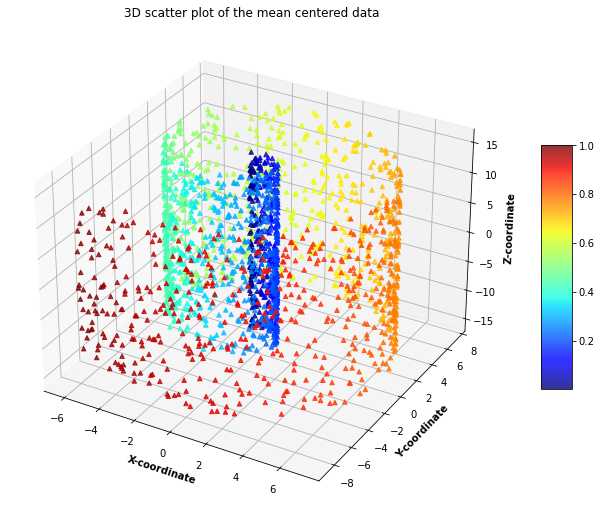

In [180]:
x = df_centered_points["x"]
y = df_centered_points["y"]
z = df_centered_points["z"]


fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)

my_cmap = plt.get_cmap('jet')
 
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = df_labels["Label"],
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("3D scatter plot of the mean centered data")
ax.set_xlabel('X-coordinate', fontweight ='bold')
ax.set_ylabel('Y-coordinate', fontweight ='bold')
ax.set_zlabel('Z-coordinate', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 8)

plt.show()

The combination of the x-, y- and z- coordinates give the swiss roll dataset a coiled shape. It can be seen as a sheet that is rolled up, with the coiled sheet being closer to itself in the center, and further away from itself when moving away from the center. The provided labels are indeed meaningful, as the beginning of the sheet (being the center position) the labels have low values, close to 0. If one rolls out the sheet and goes along from the beginning to the end of the sheet, the values of the labels start increasing, being close to 1 at the end of the sheet. For a good dimensionality reduction technique, a well-thought assumption would be to find a nonlinear technique that uncoils the space.

## Visualizing Data with PCA

In [181]:
u, s, vh = np.linalg.svd(df_centered_points , full_matrices=True)
pc_components = df_centered_points @ vh.T

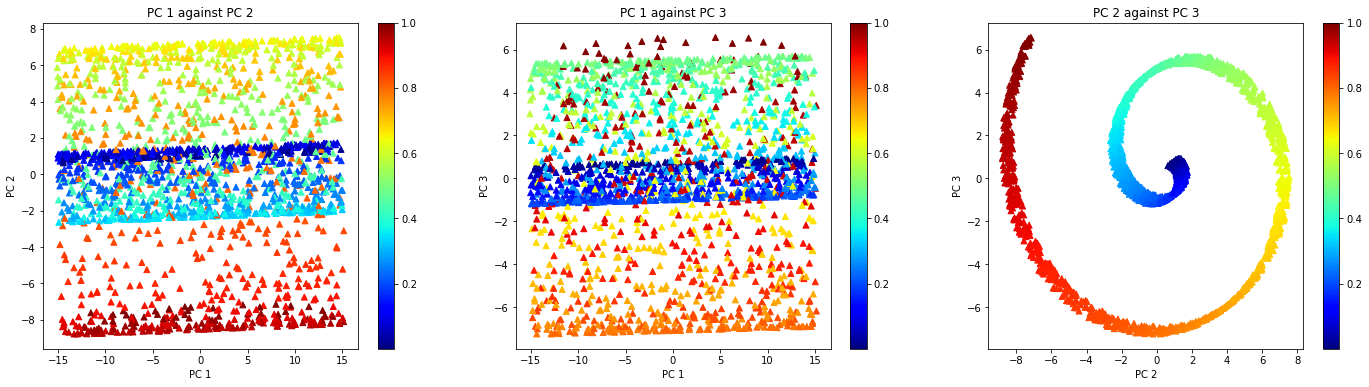

In [182]:
f, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 6))
axes = axes.ravel()
num = 0


for i in range(3):
    for j in range(3):
        if (num > 3):
            break
        elif (i < j):
            scttt = axes[num].scatter(pc_components[i], pc_components[j], c = df_labels["Label"], cmap = my_cmap, marker ='^')
            axes[num].set_title(f'PC {i+1} against PC {j+1}')
            axes[num].set_xlabel(f'PC {i+1}')
            axes[num].set_ylabel(f'PC {j+1}')
            plt.colorbar(scttt,ax=axes[num])
            num += 1

plt.show()

In [183]:
explained_variance = np.square(s)/(n-1)

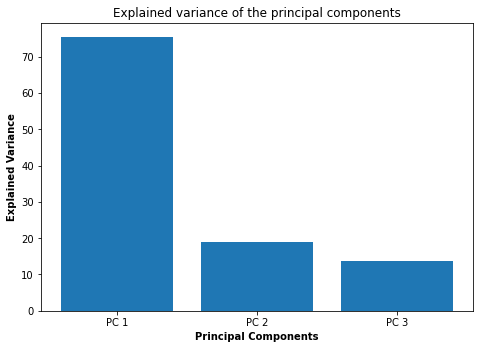

In [184]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.bar(["PC 1", "PC 2", "PC 3"], explained_variance)

plt.title("Explained variance of the principal components")
ax.set_xlabel('Principal Components', fontweight ='bold')
ax.set_ylabel('Explained Variance', fontweight ='bold')

plt.show()

##### Question 2.2

*As a dimensionality reduction technique, to what extent does PCA retain properties of the
swiss roll data set? Can you explain why the visualizations look like this, given how the algorithm works?
What can you learn about the intrinsic dimensionality from the singular values?*

The data set is so coiled that it is hard to pick up principal components using linear methods of projecting the data, in this case PCA. That is why the first two plots (PC1 vs PC2 and PC1 vs PC3) look so messy and not useful. The third plot (PC2 vs PC3) keeps the shape of the coil to a certain extent. 

PCA finds directions in the data that explain the most variance. The direction or "loading" that explains the most variance is the first right singular vector, being the first column of the matrix V. This direction corresponds to a certain extent with the z-coordinate axis. Projecting the data on the first loading gives PC1. The other two directions correspond to the second and third right singular vector, being the second and third column of the matrix V. The second loading corresponds to a certain extent with the y-coordinate axis, while the third loading corresponds to a certain extent with the x-coordinate axis.


It was chosen to plot the "explained variance" of the principal components by squaring their singular values and dividing them by (n-1). On the plot, it can be seen that PC1 explains the most variance, which was expected. The interesting part is that the explained variance of PC1 is almost four times as high as PC2. The amount of explained variance by PC2 and PC3 does not have a significant difference. Due to the significant amount of explained variance by the first principal component, one can conclude that the intrinsic dimensionality is 1 dimensional.


# Implementing Diffusion Maps

To make the upcoming coding and calculation easier, a function will be made that generates the distance matrix from a given data set. A distance matrix is a square, symmetric matrix which contains the euclidian distances between points. Let's denote the distance matrix by $E$ to avoid future confusion with the diagonal normalization matrix D.

$$
E_{i,j} = \sqrt{<x_i, x_j >} = ||x_i - x_j||
$$

In [185]:
def compute_distances(X):
    '''
    Constructs a distance matrix from data set, assumes Euclidean distance

    Inputs:
        X       a numpy array of size n x p holding the data set (n observations, p features)

    Outputs:
        D       a numpy array of size n x n containing the euclidean distances between points

    '''

    n = X.shape[0]
    D = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            D[i][j] = np.sqrt(np.sum(np.square(X[i]-X[j])))
        
    return D

The first step in the Diffusion Map algorithm is to construct the kernel matrix W, which calculates the affinities from distances. In this assignment, two kernel types will be used, being the Gaussian kernel and the adaptive k-nearest neighbors Gaussian kernel. Respectively, these kernels are defined as follows:

$$
\kappa(x_i, x_j) = \exp\left(-\frac{||x_i - x_j||^2}{\sigma^2}\right) = exp\left(-\frac{E_{i,j}^2}{\sigma^2}\right)
$$

$$
\kappa_{k-nn}(x_i, x_j) = \frac{1}{2} exp\left(-\frac{E_{i,j}^2}{\sigma_k^2(x_i)}\right) + \frac{1}{2} exp\left(-\frac{E_{i,j}^2}{\sigma_k^2(x_j)}\right)
$$

where $\sigma_k(x_j)$ is the distance from $x_j$ to its kth nearest neighbor. 

In [186]:
def compute_affinity_matrix(D, kernel_type, sigma=None, k=None):
    '''
    Construct an affinity matrix from a distance matrix via gaussian kernel.

    Inputs:
        D               a numpy array of size n x n containing the distances between points
        kernel_type     a string, either "gaussian" or "adaptive".
                            If kernel_type = "gaussian", then sigma must be a positive number
                            If kernel_type = "adaptive", then k must be a positive integer
        sigma           the non-adaptive gaussian kernel parameter
        k               the adaptive kernel parameter

    Outputs:
        W       a numpy array of size n x n that is the affinity matrix

    '''
    n = D.shape[0]
    W = np.zeros((n,n))
    
    if (kernel_type == "gaussian" and sigma > 0 and isinstance(sigma, int)):
        for i in range(n):
            for j in range(n):
                W[i][j] = np.exp(-((D[i, j])**2)/(sigma**2))
                
    elif (kernel_type == "adaptive" and k > 0 and isinstance(k, int)):
        D_sorted = np.sort(D, axis=1)
        for i in range(n):
            for j in range(n):
                W[i][j] = (1/2) * ( np.exp(-((D[i, j])**2)/((D_sorted[i, k])**2)) + 
                                    np.exp(-((D[i, j])**2)/((D_sorted[j, k])**2)) )
    else:
        print("Wrong entry, please make sure sigma or k are positive integers")
    return W

At this point, one has a pairwise similarity matrix W between the different points. The next step is to compute the Markov matrix M. The Markov matrix is a stochastic matrix with all row sums equal to one, which means it can be interpreted as defining a random walk on the graph. The Markov matrix is defined as follows:

$$
M_{i,j} = \frac{W_{i,j}}{\Sigma_j W_{i,j}}
$$

which can also be written as:

$$
M = D^{-1} W
$$

where D is the diagonal matrix of row sums, also called the diagonal normalization matrix. The Diffusion Map Algorithm is based on the right eigenvectors of the powered Markov matrix M. However, the right eigenvectors of M will not be calculated directly. Instead, use will be made of the symmetric matrix $M_s$ to compute the right eigenvectors and eigenvalues of M. The symmetric matrix $M_s$ is defined as follows:

$$
M_s = D^{-1/2} W D^{-1/2}
$$

Let $\lambda_i$ and $\psi_i$ denote the eigenvalues and right eigenvectors of the Markov matrix M and $\tilde{\lambda_i}$ and $v_i$ denote the eigenvalues and eigenvectors of $M_s$. Without prove, their relationship is given as follows:

$$
\lambda_i = \tilde{\lambda_i}
$$

$$
\psi_i = D^{-1/2} v_i 
$$

A final note is about the largest eigenvalue, the latter being equal to one. the eigenvector with the eigenvalue equal to 1 is the constant vector and, for this reason, it is called the trivial eigenvector. As the trivial eigenvector reveals no information about the data, it is discarded from the diffusion map. Note that the eigenvectors $\psi_i$ will be normalized at the end.

In [187]:
def diff_map_info(W):
    '''
    Construct the information necessary to easily construct diffusion map for any t

    Inputs:
        W           a numpy array of size n x n containing the affinities between points

    Outputs:

        diff_vec    a numpy array of size n x n-1 containing the n-1 nontrivial eigenvectors of Markov matrix 
                    as columns
        diff_eig    a numpy array of size n-1 containing the n-1 nontrivial eigenvalues of Markov matrix

        We assume the convention that the coordinates in the diffusion vectors are in descending order
        according to eigenvalues.
    '''
    # Compute the eigenpairs of the Symmetric Matrix Ms
    n = W.shape[0]
    Ddiag = np.diag(W.sum(axis=1)**(-0.5)) 
    Ms = (Ddiag) @ W @ (Ddiag)
    eigvalues, eigvecs = np.linalg.eigh(Ms)
    
    # Calculate and sort the eigenvalues of the Markov Matrix M
    indices = np.argsort(-1*eigvalues)
    diff_eig = eigvalues[indices][1:n]
    
    # Calculate the (normalized) eigenvectors of the Markov Matrix M
    eigvectors = eigvecs[:, indices]
    eigvectors = Ddiag @ eigvectors
    eigvectors = (eigvectors) / np.linalg.norm(eigvectors, axis = 0)
    diff_vec = eigvectors[:, 1:n]

    # return the info for diffusion maps
    return diff_vec, diff_eig

The last step in the algorithm is to calculate the diffusion map, which is given by

$$
\Psi_t (x_j) = (\lambda^t_2 \psi_2(j), \: \lambda^t_3 \psi_3(j), \cdots , \: \lambda^t_n \psi_3(j))
$$

In [188]:
def get_diff_map(diff_vec, diff_eig, t):
    '''
    Construct a diffusion map at t from eigenvalues and eigenvectors of Markov matrix

    Inputs:
        diff_vec    a numpy array of size n x n-1 containing the n-1 nontrivial eigenvectors of Markov matrix 
                    as columns
        diff_eig    a numpy array of size n-1 containing the n-1 nontrivial eigenvalues of Markov matrix
        t           diffusion time parameter t

    Outputs:
        diff_map    a numpy array of size n x n-1, the diffusion map defined for t
    '''
    n = diff_vec.shape[0]
    diff_map = np.zeros((n,n-1))
    
    for j in range(n):
        for i in range(n-1):
            diff_map[j][i] = (diff_eig[i]**t) * diff_vec[j][i]
    
    return diff_map

A diffusion map can be seen as the mapping between the original space and the first k eigenvectors. For each point $x$ in the data set, $\Psi_t (x)$ is an n-dimensional vector, so one can only visualize two or three dimensional slices.

# Experiment 1: Swiss Roll Dataset

The swiss roll consists of points sampled from a 2-dimensional manifold. A set $X \subset \mathbb{R}^n$ is a 2-dimensional manifold if at every point $x \in X$, a neighborhood around $x$ looks just like a section of $\mathbb{R}^2$. Geometrically, one can think of a swiss roll to be 2 dimensional sheet in 3 dimensional space (or higher).

## Visualizing Data with Diffusion Maps

#### Gaussian Kernel with width $\sigma = 3$

In [201]:
E = compute_distances(swissPoints)

In [202]:
W = compute_affinity_matrix(E, "gaussian", sigma=3)
diff_vec, diff_eig = diff_map_info(W)
diff_map = get_diff_map(diff_vec, diff_eig, 1)

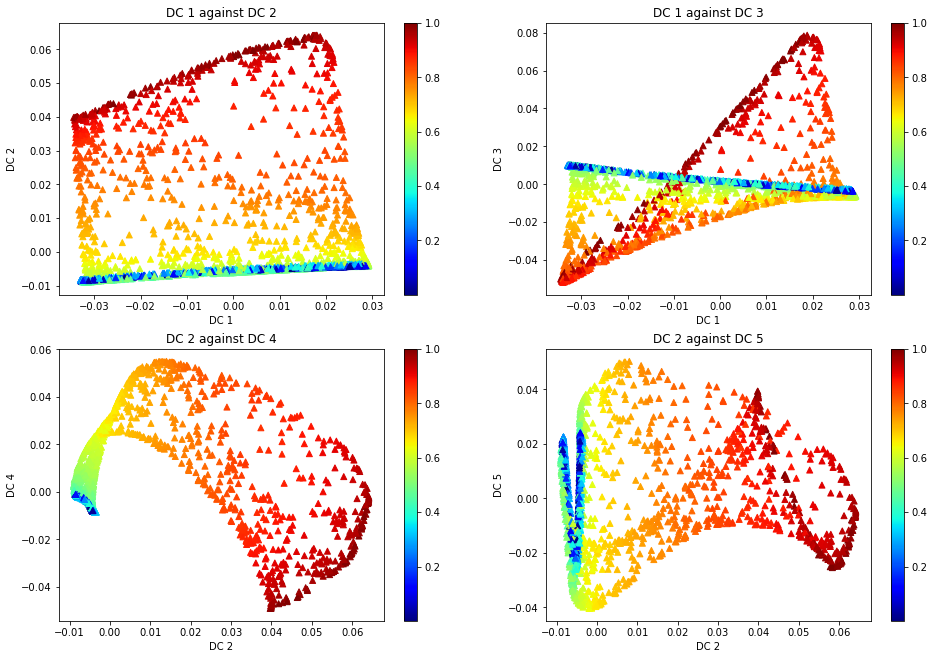

In [203]:
mn = 2

f, axes = plt.subplots(nrows = mn, ncols = mn, figsize = (16, 11))
num = 1

for i in range(mn):
    for j in range(mn):
        scttt = axes[i, j].scatter(diff_map[:, i], diff_map[:, num], c = df_labels["Label"], cmap = my_cmap, marker ='^')
        axes[i, j].set_title(f'DC {1+i} against DC {num+1}')
        axes[i, j].set_xlabel(f'DC {i+1}')
        axes[i, j].set_ylabel(f'DC {num+1}')
        plt.colorbar(scttt,ax=axes[i, j])
        num += 1
plt.show()

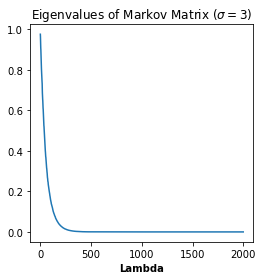

In [204]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($\sigma = 3$)")
plt.xlabel('Lambda', fontweight ='bold')

plt.plot(np.arange(1,n), diff_eig)
plt.show()

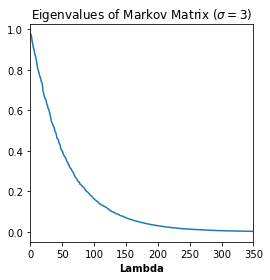

In [205]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($\sigma = 3$)")
plt.xlabel('Lambda', fontweight ='bold')
plt.xlim(right=350) 

plt.plot(np.arange(1,n), diff_eig)
plt.show()

#### Gaussian Kernel with width $\sigma = 1$

In [206]:
W = compute_affinity_matrix(E, "gaussian", sigma=1)
diff_vec, diff_eig = diff_map_info(W)
diff_map = get_diff_map(diff_vec, diff_eig, 1)

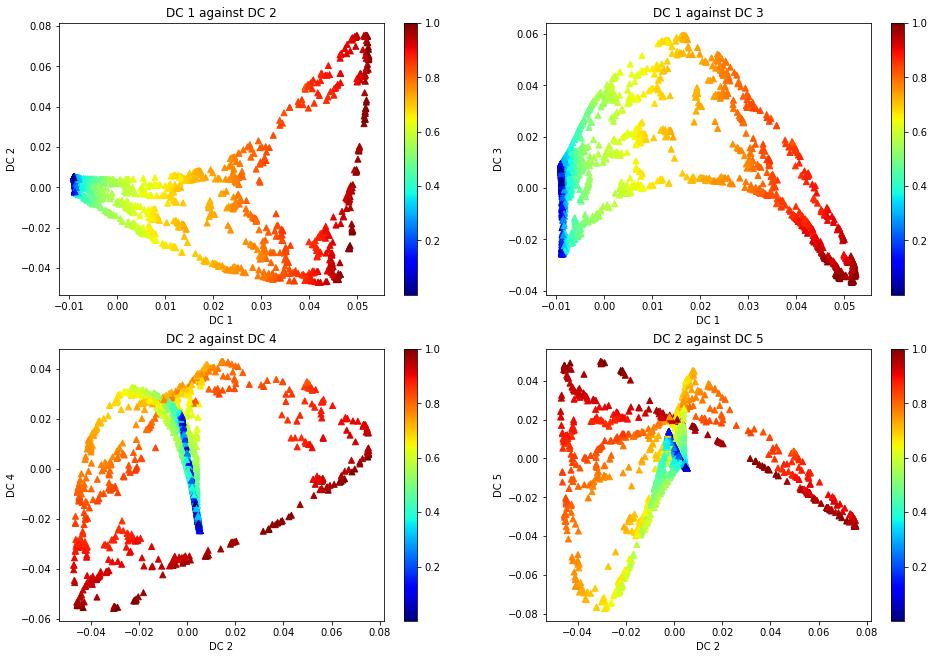

In [207]:
mn = 2

f, axes = plt.subplots(nrows = mn, ncols = mn, figsize = (16, 11))
num = 1

for i in range(mn):
    for j in range(mn):
        scttt = axes[i, j].scatter(diff_map[:, i], diff_map[:, num], c = df_labels["Label"], cmap = my_cmap, marker ='^')
        axes[i, j].set_title(f'DC {1+i} against DC {num+1}')
        axes[i, j].set_xlabel(f'DC {i+1}')
        axes[i, j].set_ylabel(f'DC {num+1}')
        plt.colorbar(scttt,ax=axes[i, j])
        num += 1
plt.show()

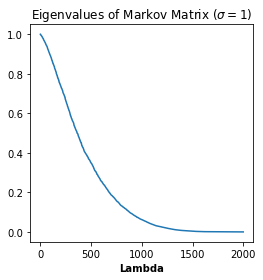

In [209]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($\sigma = 1$)")
plt.xlabel('Lambda', fontweight ='bold')

plt.plot(np.arange(1,n), diff_eig)
plt.show()

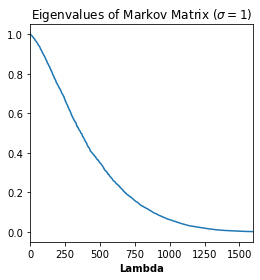

In [208]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($\sigma = 1$)")
plt.xlabel('Lambda', fontweight ='bold')
plt.xlim(right=1600) 

plt.plot(np.arange(1,n), diff_eig)
plt.show()

#### Gaussian Kernel with width $\sigma = 6$

In [210]:
W = compute_affinity_matrix(E, "gaussian", sigma=6)
diff_vec, diff_eig = diff_map_info(W)
diff_map = get_diff_map(diff_vec, diff_eig, 1)

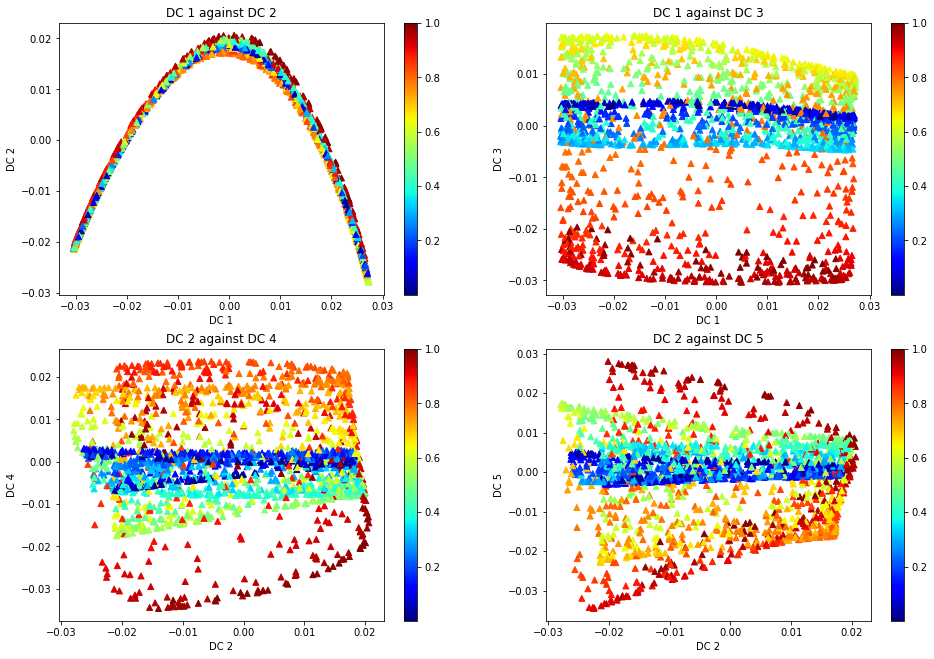

In [211]:
mn = 2

f, axes = plt.subplots(nrows = mn, ncols = mn, figsize = (16, 11))
num = 1

for i in range(mn):
    for j in range(mn):
        scttt = axes[i, j].scatter(diff_map[:, i], diff_map[:, num], c = df_labels["Label"], cmap = my_cmap, marker ='^')
        axes[i, j].set_title(f'DC {1+i} against DC {num+1}')
        axes[i, j].set_xlabel(f'DC {i+1}')
        axes[i, j].set_ylabel(f'DC {num+1}')
        plt.colorbar(scttt,ax=axes[i, j])
        num += 1
plt.show()

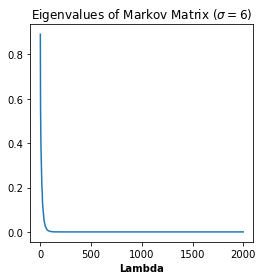

In [213]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($\sigma = 6$)")
plt.xlabel('Lambda', fontweight ='bold')

plt.plot(np.arange(1,n), diff_eig)
plt.show()

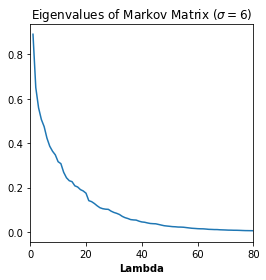

In [212]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($\sigma = 6$)")
plt.xlabel('Lambda', fontweight ='bold')
plt.xlim(right=80)

plt.plot(np.arange(1,n), diff_eig)
plt.show()

#### Question 4.1


**Influence of the Gaussian kernel width $\sigma$ on the embedding**

The diffusion map embedding, which in this case used a Gaussian kernel with width $\sigma$ equal to 3, has succeeded in unwinding the swiss roll dataset. Different combinations of diffusion components are presented in the plots, however, it is safe to say that the embedding given by the first two diffusion components gives the best results, as it clearly represents the swiss roll a two dimensional sheet, without much overlap of different regions. This is because the first non-trivial eigenvector DC1 tracks the most prominent non-linear path, being in the direction of the coiling. Using higher diffusion components for visualization leads to a folding of the sheet, as can be seen in Figure XX. The latter can be explained by the MULTIPERIODIC CHARACTER OF THESE EIGENVALUES. The diffusion mapping does a great job in retaining the properties of the swiss roll data set, both locally and globally. Remember that in the original data set, the points were colored/labeled in the direction of the coiling, with low labels (blue) in the center of the coil or the beginning of the sheet, and high labels (red) near the end of the coiled sheet. This coloring is kept in the diffusion embedding, so it can clearly be seen where the beginning and where the end of the sheet is.

The Gaussian kernel width $\sigma$ determines the range of a datapoints effective neighborhood. A Gaussian kernel with a smaller $\sigma$ (in this case $\sigma$ = 1) is more likely to tend towards closer datapoints. This is clearly visible in the plots of Figure XX, where the blue region in the embedding (low label values, located close to the center of the coil) has become a small, dense region because these points are located close to eachother in the original dataset. The orange and red region (higher label values, located near the end of the sheet) is wider and more spread out, with a certain kind of "gap" within the sheet. This is because these points are located further and more sparse in the original dataset, leading to a low connectivity for these datapoints if using a Gaussian kernel width $\sigma$ of 1. As a consequence, one should not choose $\sigma$ too low, as the kernel will focus to much on local relationships and will potentially fail to capture the global structure.

A Gaussian kernel with a higher $\sigma$ (in this case $\sigma$ = 6) will give more attention to points located further away. This is dangerous, as it could lead to losing the local structure of the original dataset, which is the case here as the diffusion embedding failed at unwrapping the swiss roll. If DC1 and DC2 are plotted against eachother, it results in an arc-like embedding, which means DC1 and DC2 are too similar (they capture the same information). Also on the other plots of Figure XX, the diffusion map algorithm for a high $\sigma$ fails to capture the non-linear structure of the data set, giving a PCA-like result. 

The above reasoning proves that the choice of $\sigma$ is very important, as the goal is the capture both the global and local properties of the dataset. 

**Influence of the Gaussian kernel width $\sigma$ on the eigenvalues of M**

Next, the intrinsic dimensionality of the data set will be investigated by looking at the eigenvalues of the Markov matrix M. In order to do this, a cutoff value in the eigenvalue plot will be used to estimate the amount of significant diffusion components. To find the cutoff value, tangent lines will be drawn on the zoomed eigenvalue plots. The point where the two tangent lines intersect will be called the "elbow point". Figure XX represents the original eigenvalue plots for different $\sigma$-values, while Figure XX gives a more zoomed in view of the important part of the plot, with the tangent lines included. Intuitively, one would expect an intrinsic dimensionality equal to 2. 

From Figures XX and XX, it is clear that the Gaussian kernel width $\sigma$ also has a significant influence on the eigenvalue plots. The elbow point on the eigenvalues plot with $\sigma$ = 6 is reached after about 70 eigenvalues, which means the amount of significant component (or intrinsic dimensionality) for this case would be 70. Of course the latter is quite high and should not be considered as accurate. 

A higher $\sigma$ leads to a smaller amount of large eigenvalues (value close to 1) and a steep eigenvalue plot that quickly drops to zero. This means that the amount of explained variance (related to the high eigenvalues) is concentrated in the first diffusion components, while the other components explain almost nothing. The elbow point is reached after 5 eigenvalues. A smaller $\sigma$ leads to a more gentle decreasing eigenvalues plot. In this case the amount of explained variance is more spread out over the first few diffusion components. In this case, the elbow point is reached after about 700 eigenvalues. 

The instrinsic dimensionality obtained for different $\sigma$-values is some order of magnitude higher than the expected value of 2, except for the case where $\sigma$ = 1. Hypothetically, one could tune the hyperparameters to obtain an eigenvalue plot where two significant diffusion components can be seen. This is, however, not the goal of this exercise 

# Understanding the First Eigenvector of the Markov Matrix

In [148]:
W = compute_affinity_matrix(E, "gaussian", sigma=1)

Ddiag = np.diag(W.sum(axis=1))
Ms = np.sqrt(np.linalg.inv(Ddiag)) @ W @ np.sqrt(np.linalg.inv(Ddiag))

eigvalues, eigvecs = np.linalg.eigh(Ms)

indices = np.argsort(-1*eigvalues)
eigvectors = eigvecs[:, indices]

LLeigvec = eigvectors[:, 0] @ np.sqrt(Ddiag)

In [149]:
LLeigvec @ (np.diag(W.sum(axis=1)**(-1)) @ W) - LLeigvec

array([-3.46944695e-17, -2.42861287e-17, -1.05818132e-16, ...,
        1.38777878e-17,  0.00000000e+00,  0.00000000e+00])

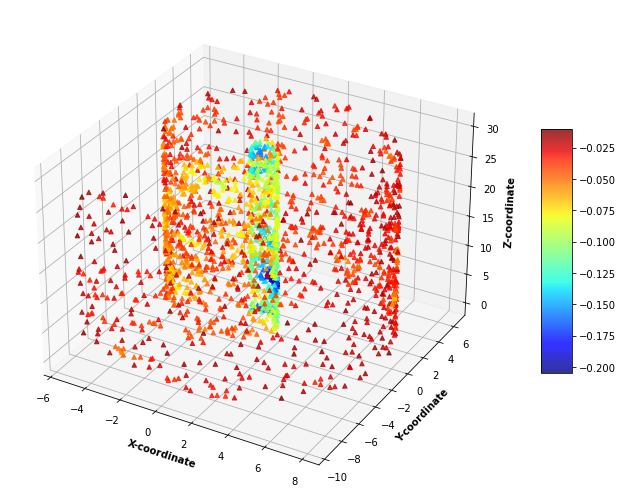

In [151]:
x = df_points["x"]
y = df_points["y"]
z = df_points["z"]


fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)

my_cmap = plt.get_cmap('jet')
 
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = LLeigvec,
                    cmap = my_cmap,
                    marker ='^')
 
ax.set_xlabel('X-coordinate', fontweight ='bold')
ax.set_ylabel('Y-coordinate', fontweight ='bold')
ax.set_zlabel('Z-coordinate', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 8)

plt.show()

#### Question 5.1:

*1) How do the values in $\phi_1$ correspond to the structure of the swiss roll? Can you explain what you are seeing in terms of diffusion?* WRITE FORMULA!!!!!!!!!

The left eigenvector $\phi_1$ of the Markov matrix represents a steady state distribution with the values corresponding to a certain kind of density estimate. The steady state distribution in the diffusion process is reached after a very long time (equal to $t$ going to infinity) when the change in the probabilities of the random walks is negligible. From a "random walk" point of view, a dense area of points is a region in which the probability of escaping this region is low, which is why the diffusion stays in this dense region for increasing t. This is also visible in the Figure XX, where the large (absolute) values of $\phi_1$, represented by the blue and green colors, are concentrated near the center of the swiss roll. This confirms that the steady state distribution is a density estimate, as near the center of the swiss roll the points are closer to eachother.

## Using an Adaptive Gaussian Kernel

#### Adaptive Gaussian Kernel with $k = 5$

In [214]:
W = compute_affinity_matrix(E, "adaptive", k=5)
diff_vec, diff_eig = diff_map_info(W)
diff_map = get_diff_map(diff_vec, diff_eig, 1)

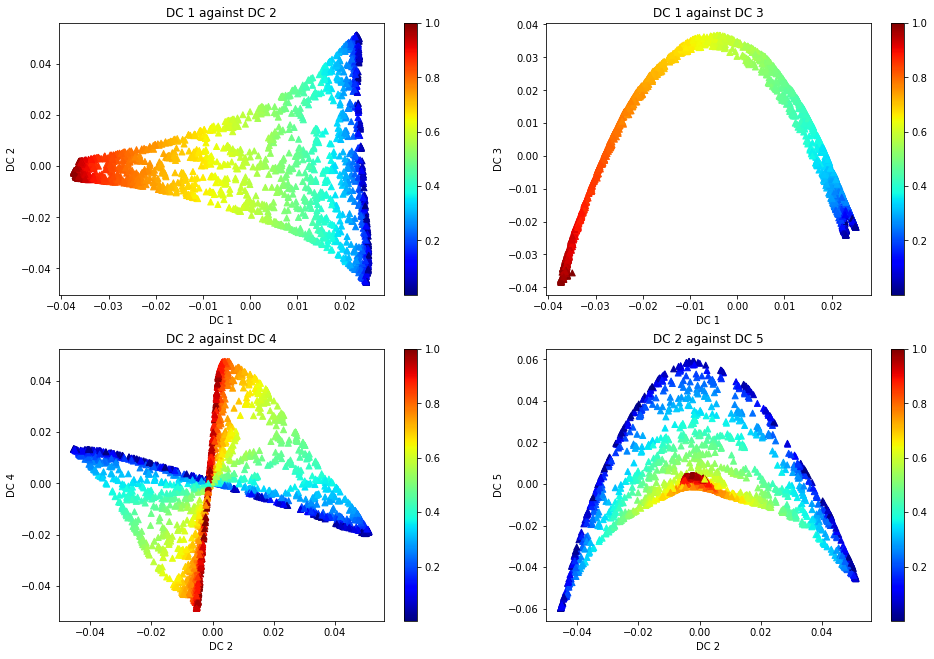

In [217]:
mn = 2

f, axes = plt.subplots(nrows = mn, ncols = mn, figsize = (16, 11))
num = 1

for i in range(mn):
    for j in range(mn):
        axes[i][j].scatter(diff_map[:, i], diff_map[:, num], c = df_labels["Label"], cmap = my_cmap, marker ='^')
        axes[i, j].set_title(f'DC {1+i} against DC {num+1}')
        axes[i, j].set_xlabel(f'DC {i+1}')
        axes[i, j].set_ylabel(f'DC {num+1}')
        plt.colorbar(scttt,ax=axes[i, j])
        num += 1
plt.show()

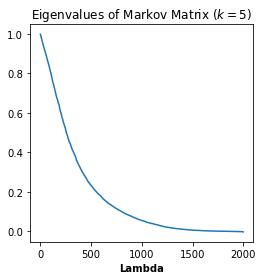

In [218]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($k = 5$)")
plt.xlabel('Lambda', fontweight ='bold')

plt.plot(np.arange(1,n), diff_eig)
plt.show()

#### Adaptive Gaussian Kernel with $k = 10$

In [219]:
W = compute_affinity_matrix(E, "adaptive", k=10)
diff_vec, diff_eig = diff_map_info(W)
diff_map = get_diff_map(diff_vec, diff_eig, 1)

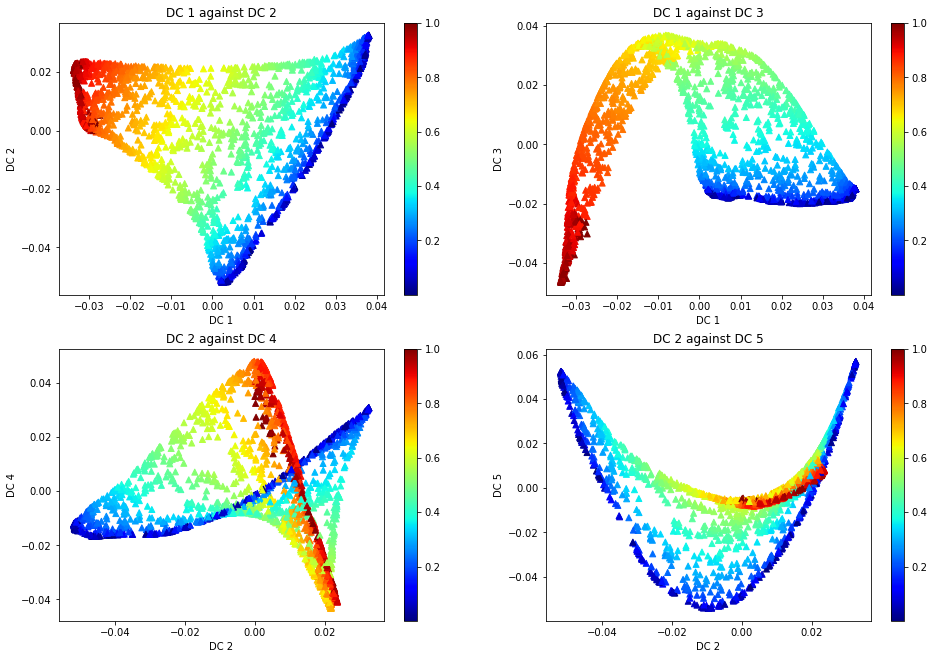

In [221]:
mn = 2

f, axes = plt.subplots(nrows = mn, ncols = mn, figsize = (16, 11))
num = 1

for i in range(mn):
    for j in range(mn):
        axes[i][j].scatter(diff_map[:, i], diff_map[:, num], c = df_labels["Label"], cmap = my_cmap, marker ='^')
        axes[i, j].set_title(f'DC {1+i} against DC {num+1}')
        axes[i, j].set_xlabel(f'DC {i+1}')
        axes[i, j].set_ylabel(f'DC {num+1}')
        plt.colorbar(scttt,ax=axes[i, j])
        num += 1
plt.show()

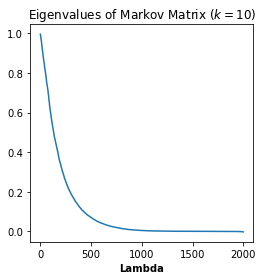

In [137]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($k = 10$)")
plt.xlabel('Lambda', fontweight ='bold')

plt.plot(np.arange(1,n), diff_eig)
plt.show()

#### Question 5.2:

What are the differences between fixed and adaptive choices of kernel parameters $\sigma$? Explain this difference. What can you learn about the intrinsic dimensionality of the data set from the eigenvalues of M? How does the choice of nearest neighbor parameter k change the diffusion map? Which kernel method would you recommend using for the swiss roll data set and why?

K = 10 is nice it spreads out better and solves the problems for 

**Differences between fixed and adaptive kernel**

In both cases (fixed and adaptive), the first two diffusion components succeed in unwrapping the swiss roll dataset. Consequently, this discussion will mainly concern the embeddings of DC1 and DC2. In case of the fixed kernel parameter $\sigma$, the value stays the same througout the whole dataset. In case an adaptive kernel parameter $\sigma_k$ is used, however, the value of $\sigma_k$ will change according to the density of the considered region. In denser regions, for example the center of the swiss roll, the value of $\sigma_k$ will be low, as the considered data point has many neighbors which are closely located. In sparse regions, for example the end of the swiss roll, the value of $\sigma_k$ will be higher, as the points are located further away. 

If one compares the DC1-DC2 plot for the adaptive kernel with the fixed kernel that uses a $\sigma = 3$, one can find a noticeable difference in the shape of the embedding. The use of an adaptive kernel has a rather wedge-shaped embedding, while the fixed kernel gives an almost rectangular embedding. The narrow side of the wedge shape (red color, high value labels) corresponds with the end of the swiss roll, being the sparse area of points where $\sigma_k$ will be higher. As mentioned above, using a large $\sigma_k$ will lead to capturing the same information, which is why these points are located close to eachother in the embedding. The wider side of the wedge shape (blue color, low value labels) corresponds with the center of the swiss roll, being the dense area of points where $\sigma_k$ will be low.

**Influence of the parameter k**

By looking at the eigenvalues plots, the intrinsic dimensionality can be derived by checking when the cut off value is reached. The latter is found by using the elbow point method like previously done. For k = 5, the eigenvalues plot shows a more gentle slope, with the elbow point reached after about 500 eigenvalues. The eigenvalues plot for k = 10 is somewhat steeper, reaching its elbow point after around 300 eigenvalues. 

If k increases, the wedge-shaped embedding gets wider

## Changing the Diffusion Parameter t

In [239]:
W = compute_affinity_matrix(E, "adaptive", k=10)
diff_vec, diff_eig = diff_map_info(W)

#### Adaptive Gaussian Kernel with $k = 10$ and $t = 1$

In [240]:
diff_map = get_diff_map(diff_vec, diff_eig, 1)

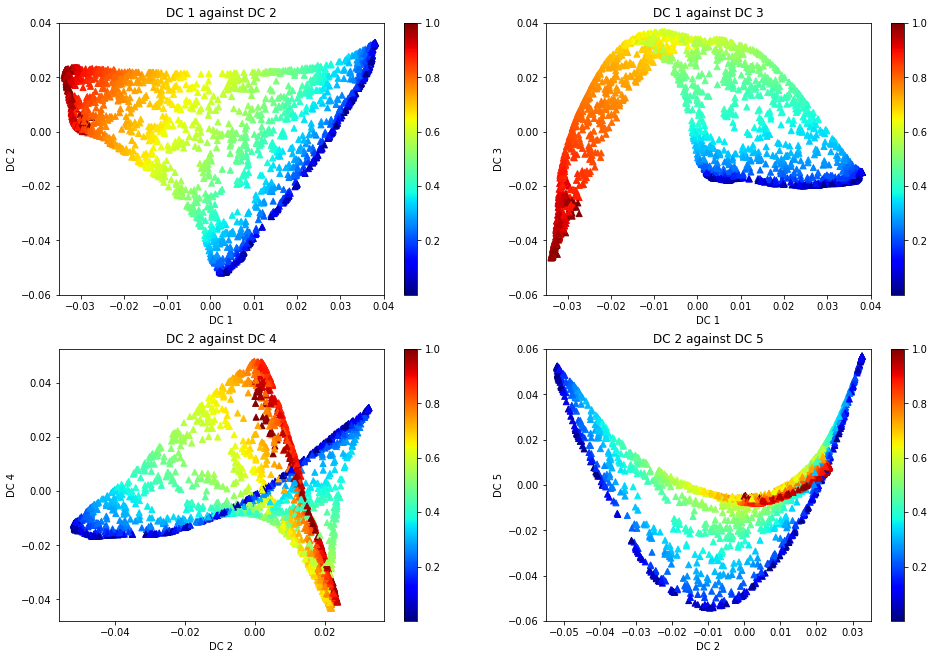

In [241]:
mn = 2

f, axes = plt.subplots(nrows = mn, ncols = mn, figsize = (16, 11))
num = 1

for i in range(mn):
    for j in range(mn):
        scttt = axes[i][j].scatter(diff_map[:, i], diff_map[:, num], c = df_labels["Label"], cmap = my_cmap, marker ='^')
        axes[i, j].set_title(f'DC {1+i} against DC {num+1}')
        axes[i, j].set_xlabel(f'DC {i+1}')
        axes[i, j].set_ylabel(f'DC {num+1}')
        plt.colorbar(scttt,ax=axes[i, j])
        if (i == 0 & j == 0):
            axes[i, j].set_xlim([-0.035,0.04])
            axes[i, j].set_ylim([-0.06,0.04])
        elif (i == 0 & j == 1):
            axes[i, j].set_xlim([-0.04,0.04])
            axes[i, j].set_ylim([-0.05,0.04])
        elif (i == 1 & j == 0):
            axes[i, j].set_xlim([-0.06,0.04])
            axes[i, j].set_ylim([-0.05,0.05])
        elif (i == 1 & j == 1):
            axes[i, j].set_xlim([-0.055,0.035])
            axes[i, j].set_ylim([-0.06,0.06])
        num += 1
plt.show()

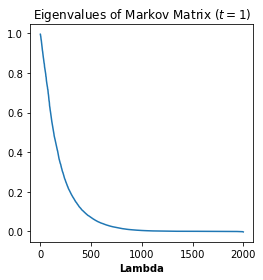

In [242]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($t = 1$)")
plt.xlabel('Lambda', fontweight ='bold')
#plt.xlim(right = 700)

plt.plot(np.arange(1,n), diff_eig**1)
plt.show()

#### Adaptive Gaussian Kernel with $k = 10$ and $t = 10$

In [243]:
diff_map = get_diff_map(diff_vec, diff_eig, 10)

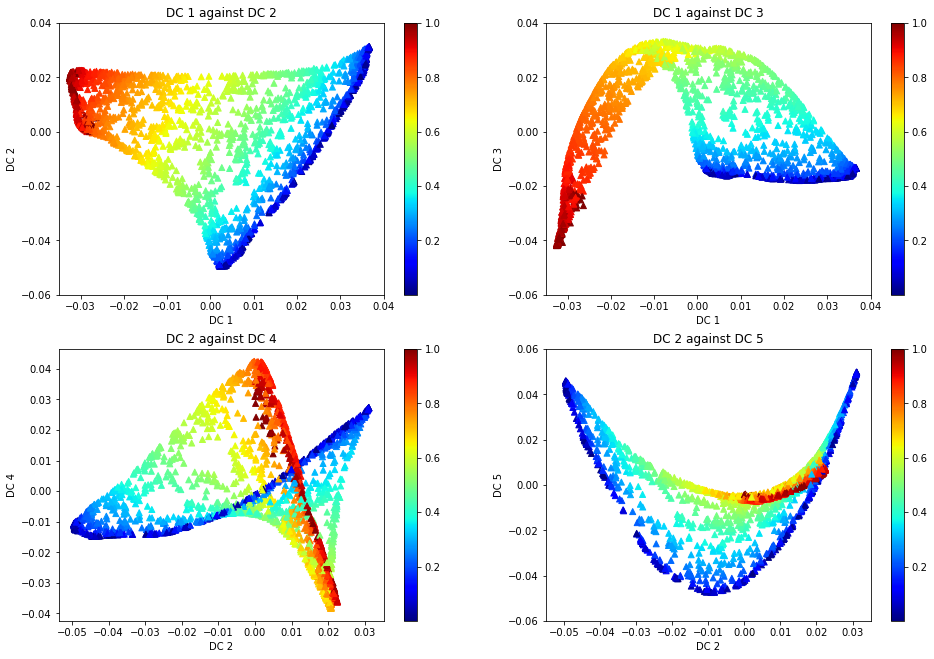

In [244]:
mn = 2

f, axes = plt.subplots(nrows = mn, ncols = mn, figsize = (16, 11))
num = 1

for i in range(mn):
    for j in range(mn):
        scttt = axes[i][j].scatter(diff_map[:, i], diff_map[:, num], c = df_labels["Label"], cmap = my_cmap, marker ='^')
        axes[i, j].set_title(f'DC {1+i} against DC {num+1}')
        axes[i, j].set_xlabel(f'DC {i+1}')
        axes[i, j].set_ylabel(f'DC {num+1}')
        plt.colorbar(scttt,ax=axes[i, j])
        if (i == 0 & j == 0):
            axes[i, j].set_xlim([-0.035,0.04])
            axes[i, j].set_ylim([-0.06,0.04])
        elif (i == 0 & j == 1):
            axes[i, j].set_xlim([-0.04,0.04])
            axes[i, j].set_ylim([-0.05,0.04])
        elif (i == 1 & j == 0):
            axes[i, j].set_xlim([-0.06,0.04])
            axes[i, j].set_ylim([-0.05,0.05])
        elif (i == 1 & j == 1):
            axes[i, j].set_xlim([-0.055,0.035])
            axes[i, j].set_ylim([-0.06,0.06])
        num += 1
plt.show()

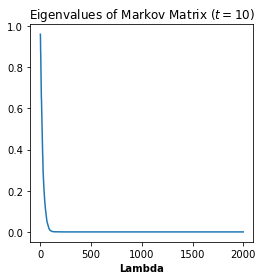

In [245]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($t = 10$)")
plt.xlabel('Lambda', fontweight ='bold')
#plt.xlim(right = 100)

plt.plot(np.arange(1,n), diff_eig**10)
plt.show()

#### Adaptive Gaussian Kernel with $k = 10$ and $t = 20$

In [246]:
diff_map = get_diff_map(diff_vec, diff_eig, 20)

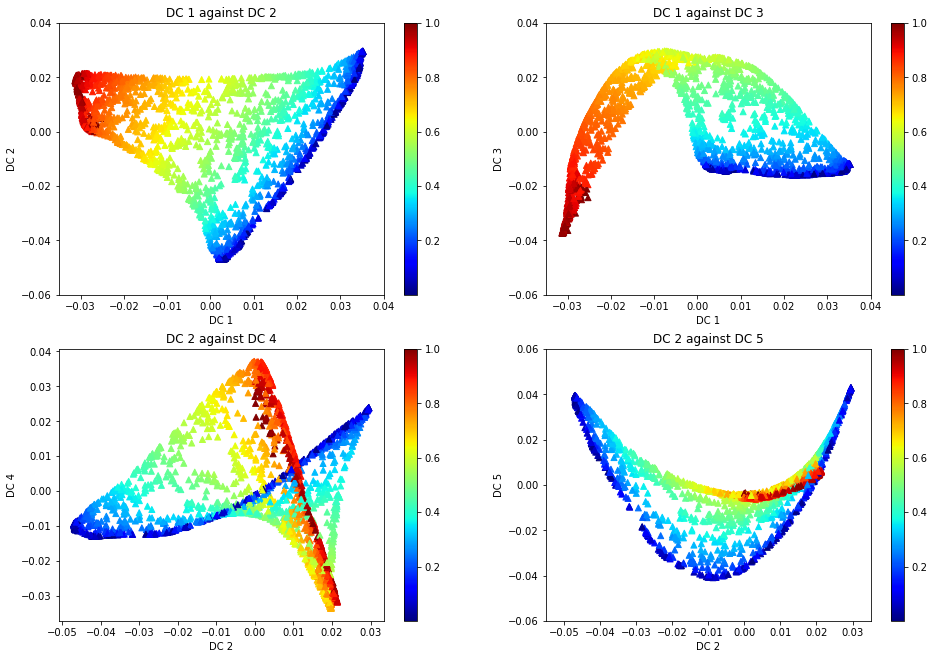

In [247]:
mn = 2

f, axes = plt.subplots(nrows = mn, ncols = mn, figsize = (16, 11))
num = 1

for i in range(mn):
    for j in range(mn):
        scttt = axes[i][j].scatter(diff_map[:, i], diff_map[:, num], c = df_labels["Label"], cmap = my_cmap, marker ='^')
        axes[i, j].set_title(f'DC {1+i} against DC {num+1}')
        axes[i, j].set_xlabel(f'DC {i+1}')
        axes[i, j].set_ylabel(f'DC {num+1}')
        plt.colorbar(scttt,ax=axes[i, j])
        if (i == 0 & j == 0):
            axes[i, j].set_xlim([-0.035,0.04])
            axes[i, j].set_ylim([-0.06,0.04])
        elif (i == 0 & j == 1):
            axes[i, j].set_xlim([-0.04,0.04])
            axes[i, j].set_ylim([-0.05,0.04])
        elif (i == 1 & j == 0):
            axes[i, j].set_xlim([-0.06,0.04])
            axes[i, j].set_ylim([-0.05,0.05])
        elif (i == 1 & j == 1):
            axes[i, j].set_xlim([-0.055,0.035])
            axes[i, j].set_ylim([-0.06,0.06])
        num += 1
plt.show()

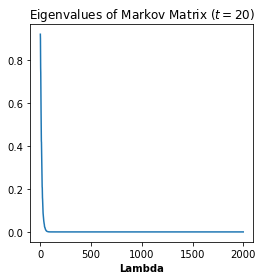

In [248]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($t = 20$)")
plt.xlabel('Lambda', fontweight ='bold')
#plt.xlim(right = 100)

plt.plot(np.arange(1,n), diff_eig**20)
plt.show()

#### Adaptive Gaussian Kernel with $k = 10$ and $t = 50$

In [252]:
diff_map = get_diff_map(diff_vec, diff_eig, 50)

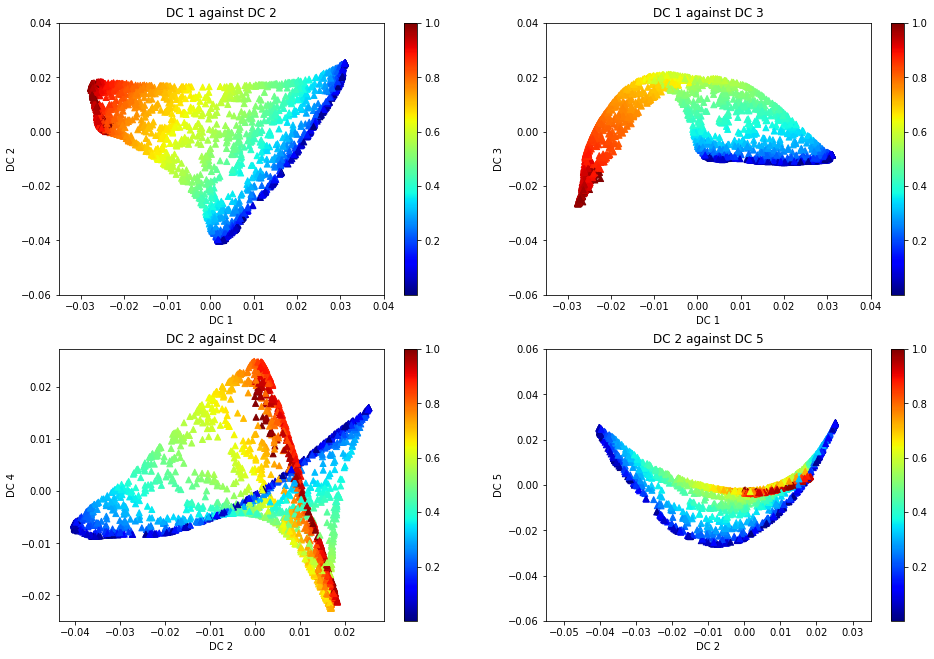

In [253]:
mn = 2

f, axes = plt.subplots(nrows = mn, ncols = mn, figsize = (16, 11))
num = 1

for i in range(mn):
    for j in range(mn):
        scttt = axes[i][j].scatter(diff_map[:, i], diff_map[:, num], c = df_labels["Label"], cmap = my_cmap, marker ='^')
        axes[i, j].set_title(f'DC {1+i} against DC {num+1}')
        axes[i, j].set_xlabel(f'DC {i+1}')
        axes[i, j].set_ylabel(f'DC {num+1}')
        plt.colorbar(scttt,ax=axes[i, j])
        if (i == 0 & j == 0):
            axes[i, j].set_xlim([-0.035,0.04])
            axes[i, j].set_ylim([-0.06,0.04])
        elif (i == 0 & j == 1):
            axes[i, j].set_xlim([-0.04,0.04])
            axes[i, j].set_ylim([-0.05,0.04])
        elif (i == 1 & j == 0):
            axes[i, j].set_xlim([-0.06,0.04])
            axes[i, j].set_ylim([-0.05,0.05])
        elif (i == 1 & j == 1):
            axes[i, j].set_xlim([-0.055,0.035])
            axes[i, j].set_ylim([-0.06,0.06])
        num += 1
plt.show()

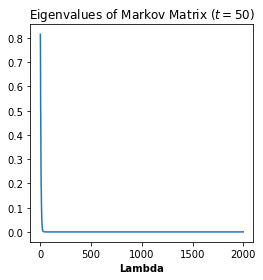

In [254]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($t = 50$)")
plt.xlabel('Lambda', fontweight ='bold')

plt.plot(np.arange(1,n), diff_eig**50)
plt.show()

#### Question 5.3: 

In terms of diffusion processes, what is the interpretation of increasing t? How do the diffusion embeddings visually change as t increases? How do the eigenvalues change and how does this help explain what you see in the embeddings? What can you learn about the intrinsic dimensionality of the data set from the eigenvalues of M as t increases? Is there a specific value of t that you  found most informative for the Swiss roll data set?

Diffusion maps make use of random walks to reveal to underlying structure of the dataset. The number of steps in the random walk (from one datapoint to another) is denoted by $t$, so with increasing values of $t$ the diffusion process “runs forward” and the probability of following a path along the underlying geometric structure of the data set increases. This can be explained by the fact that, along the geometric structure of a data set, the data points are dense and therefore highly connected, leading to pathways along short (high probability) steps. This is the reason why for the steady state situation, the probability of escaping a dense region is low. Points that do not follow the geometric structure (or noise points) will have a very low probability of walking towards it.


When comparing the diffusion embeddings for different t-values in Figures XX to XX, it can be seen that the overall shape of the embeddings does not change. This is because the diffusion components only change by a factor equal to the corresponding eigenvalue $\lambda_i$, which makes scaling the only visual change. As the eigenvalues are powered to the power of $t$, the diffusion components with small and intermediate values will quickly decay for increasing t, so only the most prominent ones (with eigenvalues close to 1) will be left. This can also be seen in the eigenvalue plots, which become steeper for increasing values of $t$. 

The effect of increasing $t$ on the different diffusion components can be seen by comparing the different plots and their axes scales. In case of the embeddings created by DC1 and DC2, the values on the axes only start changing significantly after $t = 50$. For lower $t$-values there is a negligible difference in the plots. Because the eigenvalues are close to one, powering them to small values of $t$ changes little. A more significant change in the axes scales for increasing $t$-values can for example be found in the plots of the embeddings created by DC2 and DC5. The higher the number of the diffusion component, the more the embedding will be affected (as the eigenvalues are closer to zero). The estimated intrinsic dimensionality of the data set for t = 1, 10, 20, and 50, is respectively around 300, 30, 20 and 10. The fact that the intrinsic dimensionality decreases for increasing $t$-values was expected as only the higher eigenvalues remain prominent. 

As the plots for the first diffusion components stay rather the same fot $t$-values in the range from 1 to 50, the choice of $t$ is less important. This is because the eigenvalues for the first diffusion components are close to 1. the For the Swiss Roll data set, a good choice would be to have a t in between 20 and 50.

## Final Thoughts


#### Question 5.4:

Suppose your boss is very delighted by your implementation of diffusion mappings and the initial tests on the swiss roll dataset; however, she would like to see how the method works on other artificial control data sets. Describe two other data sets that you might generate and what you would expect to see from these tests. You do not need to construct these two data sets.

Dimensionality reduction by using diffusion maps is useful in many other cases. A first example is a data set which consists of non-uniformly sampled data points on a toroidal helix. The first two diffusion map coordinates will unravel the toroidal helix, recovering the underlying intrinsic circular geometry of the data. An other example is the lips dataset, which represents images of spoken digits. Images are very high dimensional, but if one would apply diffusion maps on the, it can be seen that the variation is basically only along two dimensions. One is the opening of the mouth, and the other one is the visible portion of the teeth.

# Experiment 2: iPSC Reprogamming Dataset

In [255]:
iPSC_names = load_json_files("/Users/louisdeschuttere/Documents/Yale University/Semester 1/Unsupervised Learning/Homework1/Data/ipsc_channel_names.json")
iPSC_data = load_json_files("/Users/louisdeschuttere/Documents/Yale University/Semester 1/Unsupervised Learning/Homework1/Data/ipsc_data.json")

In [256]:
n = iPSC_data.shape[0]
p = iPSC_data.shape[1]
n

2005

In [257]:
df_PSCdata = pd.DataFrame(iPSC_data, columns=iPSC_names)
df_PSClabels = pd.DataFrame(np.arange(1,n+1), columns=["Label"])
df_PSCnames = pd.DataFrame(iPSC_names, columns=["Names"])

## Visualizing Data with PCA

In [262]:
df_PSCdata_centered = df_PSCdata - df_PSCdata.mean()
u, s, vh = np.linalg.svd(df_PSCdata_centered , full_matrices=False)
pc_components = df_PSCdata_centered @ vh.T

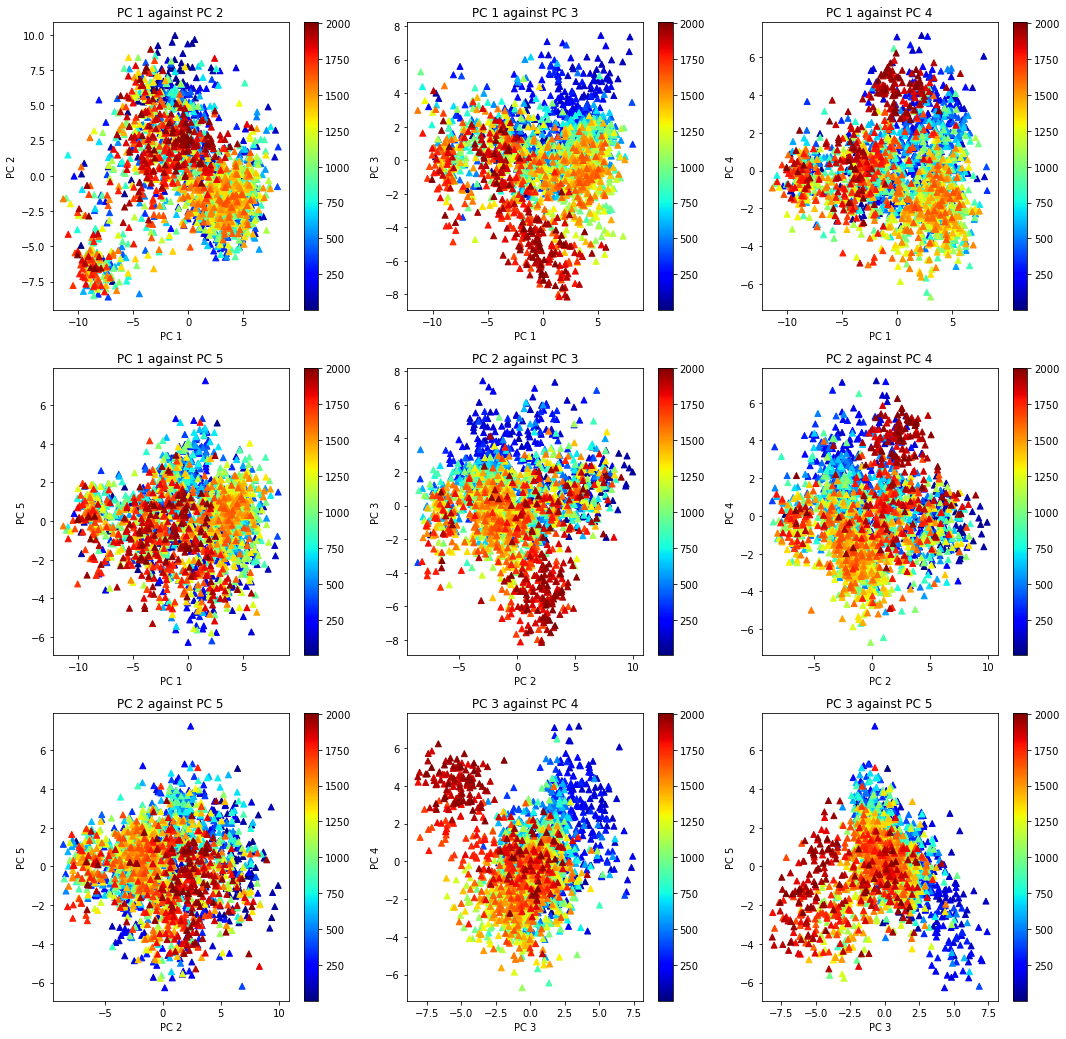

In [263]:
mn = 3
num = 0

f, axes = plt.subplots(nrows = mn, ncols = mn, figsize = (18, 18))
axes = axes.ravel()

for i in range(5):
    for j in range(5):
        if (num > 8):
            break
        elif (i < j):
            scttt = axes[num].scatter(pc_components[i], pc_components[j], c = df_PSClabels["Label"], cmap = my_cmap, marker ='^')
            axes[num].set_title(f'PC {i+1} against PC {j+1}')
            axes[num].set_xlabel(f'PC {i+1}')
            axes[num].set_ylabel(f'PC {j+1}')
            plt.colorbar(scttt,ax=axes[num])
            num += 1

plt.show()

In [264]:
explained_variance = np.square(s)/(n-1)
col_list = ['PC ' + str(n + 1) for n in range(33)]

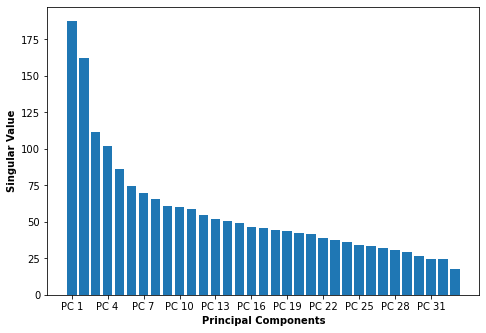

In [265]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.bar(col_list, s)

#plt.title("Singular values of the principal components")
ax.set_xlabel('Principal Components', fontweight ='bold')
ax.set_ylabel('Singular Value', fontweight ='bold')

plt.xticks(range(0,32,3))

plt.show()

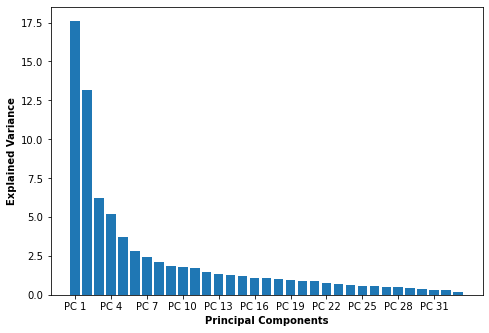

In [266]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.bar(col_list, explained_variance)

#plt.title("Explained variance of the principal components")
ax.set_xlabel('Principal Components', fontweight ='bold')
ax.set_ylabel('Explained Variance', fontweight ='bold')

plt.xticks(range(0,32,3))

plt.show()

In [160]:
PC1_topChannels = [df_PSCnames["Names"][i] for i in np.argsort(-1*abs(vh.T[:,0]))[0:5]]
print("Top five channels in first principal direction:", PC1_topChannels)

Top five channels in first principal direction: ['oct4', 'ki67', 'klf4', 'h3k9ac', 'prb']


In [161]:
PC2_topChannels = [df_PSCnames["Names"][i] for i in np.argsort(-1*abs(vh.T[:,1]))[0:5]]
print("Top five channels in second principal direction:", PC2_topChannels)

Top five channels in second principal direction: ['bcatenin', 'ikba', 'thy1', 'ps6', 'pstat3-727']


#### Question 6.1:

How do the PCA visualizations look? Are they capturing the time progression of the data set? Do you see any clusters forming? What is the intrinsic dimensionality given by PCA? What are the top few channels in the first and second principal directions?

BLOBS ARE GENERATED, FACT THAT 3 AND 4 ARE GIVING GOOD RESULTS IS STRANGE


In general, PCA did not succeed in representing the data in a 2-dimensional representation, leading to clusters of data points overlapping with eachother. Only when PC3 is used, one can somewhat distinguish clusters of low timepoints (blue zone) and high timepoints (red zone), but in between these extremes the datapoints are again overlapping. As a consequence, one should not use PCA to capture the time progression of the data set. This is because PCA searches for linear directions that explain maximum variance in the data. Time progression in the data set can be (and will probably be) non-linear. Therefore it is recommended to use a non-linear dimensionality reduction technique.

To estimate the intrinsic dimensionality given by PCA, the plot of the explained variance of the Principal Components will be used. As there are only 33 Principal components, the intrinsic dimensionality will be directly deducted from the plot, without using the elbow method. On Figure XX it can be seen that there are two prominent Principal Components which explain most of the variance. As a consequence, one could estimate the intrinsic dimensionality given by PCA to be 2.

To calculate the top five channels in the first principal directions, the first right singular eigenvector will be investigated. The indices of the five larges absolute values in the eigenvector will be extracted and these will be used in the channel names vector. For the first principal direction, this gives:

$t_{PC1,5} = [oct4, \: ki67,\: klf4,\: h3k9ac,\: prb]$

The same reasoning is used fot the second principal direction, which gives:

$t_{PC2,5} = [bcatenin, \: ikba, \: thy1, \: ps6, \: pstat3-727]$

ORTHOGONAL SO LOGIC THAT THEY ARE DIFFERENT.

## Visualizing Data with Diffusion Maps

In [267]:
E = compute_distances(iPSC_data)
W = compute_affinity_matrix(E, "adaptive", k=2)
diff_vec, diff_eig = diff_map_info(W)
diff_map = get_diff_map(diff_vec, diff_eig, 1)

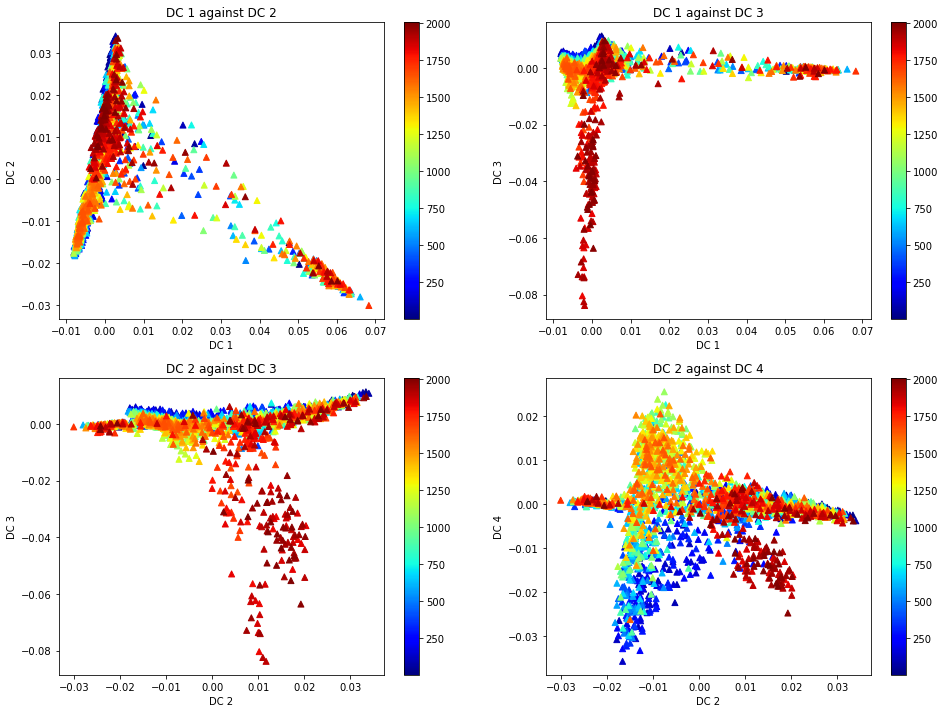

In [268]:
mn = 2

f, axes = plt.subplots(nrows = mn, ncols = mn, figsize = (16, 12))
num = 0

for i in range(mn):
    num = 0
    for j in range(mn):
        num += 1
        axes[i][j].scatter(diff_map[:, i], diff_map[:, num + i], c = df_PSClabels["Label"], cmap = my_cmap, marker ='^')
        axes[i, j].set_title(f'DC {1+i} against DC {num+1 + i}')
        axes[i, j].set_xlabel(f'DC {i+1}')
        axes[i, j].set_ylabel(f'DC {num+1+i}')
        plt.colorbar(scttt,ax=axes[i, j])
plt.show()

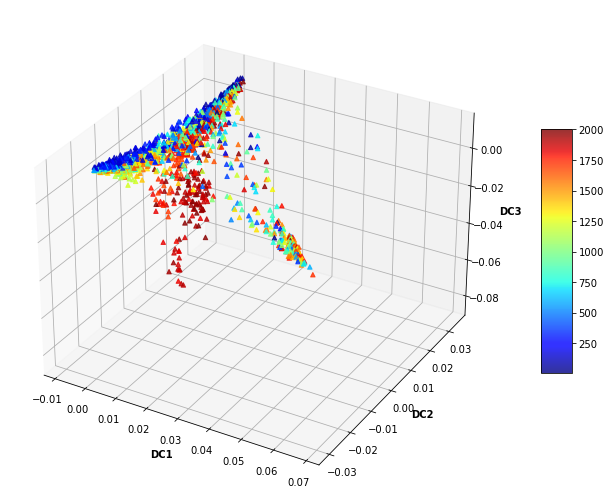

In [273]:
x = diff_map[:, 0]
y = diff_map[:, 1]
z = diff_map[:, 2]


fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)

my_cmap = plt.get_cmap('jet')
 
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = df_PSClabels["Label"],
                    cmap = my_cmap,
                    marker ='^')
 
#plt.title("3D scatter plot of the diffusion mapping (first three coordinates)")
ax.set_xlabel('DC1', fontweight ='bold')
ax.set_ylabel('DC2', fontweight ='bold')
ax.set_zlabel('DC3', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 8)

plt.show()

In [279]:
diff_eig

array([ 0.74108855,  0.65443817,  0.48866713, ...,  0.0020484 ,
       -0.00162363, -0.03001898])

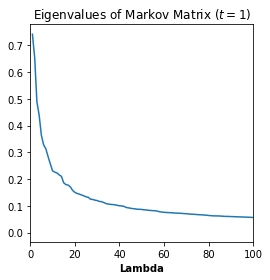

In [278]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($t = 1$)")
plt.xlabel('Lambda', fontweight ='bold')
plt.xlim(right = 100)

plt.plot(np.arange(1,n-4), diff_eig[0:n-5])
plt.show()

In [271]:
def corr_DC1(dm, df):
    n = df.shape[0]
    p = df.shape[1]
    helpList = np.zeros(n)
    
    for i in range(p):
        helpList[i] = np.abs(stats.pearsonr(dm[:, 0], df.iloc[:,i])[0])

    topDC1 = [df_PSCnames["Names"][j] for j in np.argsort(-1*helpList)[0:5]]
    print("Channels that have a high correlation with DC1:", topDC1)
    
def corr_DC2(dm, df):
    n = df.shape[0]
    p = df.shape[1]
    helpList = np.zeros(n)
    
    for i in range(p):
        helpList[i] = np.abs(stats.pearsonr(dm[:, 1], df.iloc[:,i])[0])

    topDC1 = [df_PSCnames["Names"][j] for j in np.argsort(-1*helpList)[0:5]]
    print("Channels that have a high correlation with DC2:", topDC1)
    
def corr_DC3(dm, df):
    n = df.shape[0]
    p = df.shape[1]
    helpList = np.zeros(n)
    
    for i in range(p):
        helpList[i] = np.abs(stats.pearsonr(dm[:, 2], df.iloc[:,i])[0])

    topDC1 = [df_PSCnames["Names"][j] for j in np.argsort(-1*helpList)[0:5]]
    print("Channels that have a high correlation with DC3:", topDC1)

In [272]:
corr_DC1(diff_map, df_PSCdata_centered)
corr_DC2(diff_map, df_PSCdata_centered)
corr_DC3(diff_map, df_PSCdata_centered)

Channels that have a high correlation with DC1: ['h3k9ac', 'prb', 'pplk1', 'pstat3-727', 'pampk']
Channels that have a high correlation with DC2: ['bcatenin', 'cd140a', 'ikba', 'mefsk4', 'oct4']
Channels that have a high correlation with DC3: ['lin28', 'ssea1', 'epcam', 'cd44', 'gfp']


#### Question 6.2

How do the Diffusion Map visualizations look? Are they capturing the time progression of the data set? Do you see any clusters forming? What is the intrinsic dimensionality given by Diffusion Maps? Which channels are most highly correlated with diffusion components? Any guesses to the biological interpretation? What are the main differences between Diffusion Maps and PCA methods on the iPSC dataset?

The 3-dimensional embedding according to the first three diffusion components gives an arc like region with two "pointy appendages". The low timepoints (blue color) are located in this arc-like cluster, together with a significant amount of the intermediate timepoints. The upper "appendage" contains a large variety of timepoints, with some higher timepoints at the pointy end of the appendage. The lower "appendage" has most of the higher timepoints, which means the diffusion map kind of succeeds in capturing the time progression of the data set. This structure is less clearly visible in the 2-dimensional scatter plot. The embedding according to DC1 and DC2, for example, gives a lot of overlap and the clusters are less clear. In the embedding according to DC1 and DC3, however, one can see the two "appendages". It is more meaningful to represent this data in three dimensions.

The main difference with PCA is that diffusion maps better capture the time progression of the data set. PCA generates principal components who fail in clustering the data and nicely representing it, while the diffusion map method does a better job in this. The reason for this is that diffusion map is a non-linear dimensionality reduction technique. The eigenvalue plot, together with a more zoomed in version is shown in Figures XX and XX. Using a cut off value and the elbow method, the intrinsic dimensionality is estimated to be around 5. An other noticeable aspect is that the first eigenvalues are somewhat lower than 1 and very different, with the first three eigenvalues being 0.74,  0.65, and 0.49. For the Swiss roll dataset, the first eigenvalues were closer to one and less different. 

Next, the top 5 channels that have the highest absolute correlation with the first, second, and third
diffusion components will be computed. The correlation between the diffusion map vector and the channel vector will be calculated with Pearson's correlation coefficient. The top 5 channels that have a high correlation with DC1 are: 

$[h3k9ac,\: prb, \:  pplk1, \: pstat3-727, \: pampk]$

The top 5 channels that have a high correlation with DC2 are: 

$[bcatenin, \: cd140a,\:  ikba, \: mefsk4,\:  oct4]$

The top 5 channels that have a high correlation with DC3 are: 

$[lin28, \: ssea1,\:  epcam,\:  cd44, \: gfp]$

If one




## Changing Parameters

#### t = 10

In [168]:
diff_map = get_diff_map(diff_vec, diff_eig, 10)

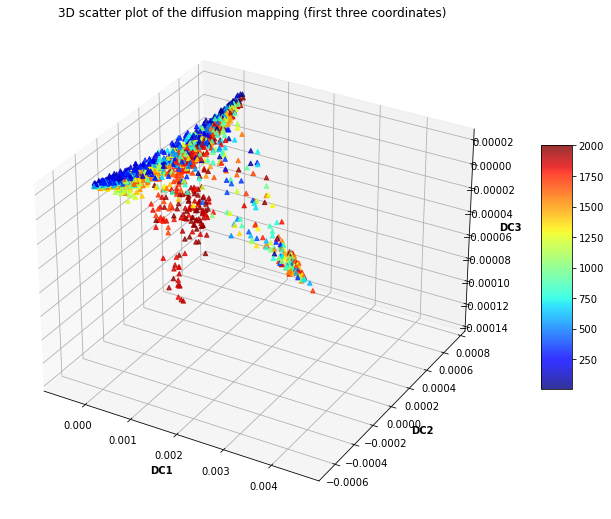

In [169]:
x = diff_map[:, 0]
y = diff_map[:, 1]
z = diff_map[:, 2]


fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)

my_cmap = plt.get_cmap('jet')
 
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = df_PSClabels["Label"],
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("3D scatter plot of the diffusion mapping (first three coordinates)")
ax.set_xlabel('DC1', fontweight ='bold')
ax.set_ylabel('DC2', fontweight ='bold')
ax.set_zlabel('DC3', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 8)

plt.show()

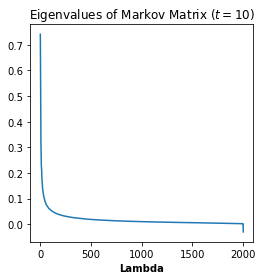

In [170]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($t = 10$)")
plt.xlabel('Lambda', fontweight ='bold')

plt.plot(np.arange(1,n), diff_eig**10)
plt.show()

#### t = 50

In [171]:
diff_map = get_diff_map(diff_vec, diff_eig, 50)

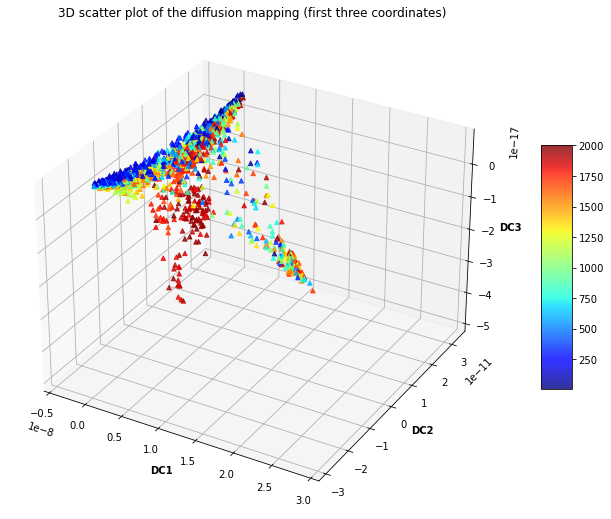

In [172]:
x = diff_map[:, 0]
y = diff_map[:, 1]
z = diff_map[:, 2]


fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)

my_cmap = plt.get_cmap('jet')
 
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = df_PSClabels["Label"],
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("3D scatter plot of the diffusion mapping (first three coordinates)")
ax.set_xlabel('DC1', fontweight ='bold')
ax.set_ylabel('DC2', fontweight ='bold')
ax.set_zlabel('DC3', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 8)

plt.show()

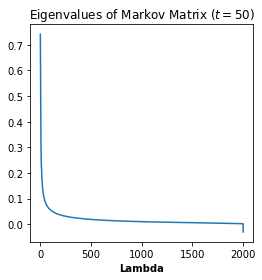

In [173]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($t = 50$)")
plt.xlabel('Lambda', fontweight ='bold')

plt.plot(np.arange(1,n), diff_eig**50)
plt.show()

##### k = 5

In [174]:
W = compute_affinity_matrix(E, "adaptive", k=5)
diff_vec, diff_eig = diff_map_info(W)
diff_map = get_diff_map(diff_vec, diff_eig, 1)

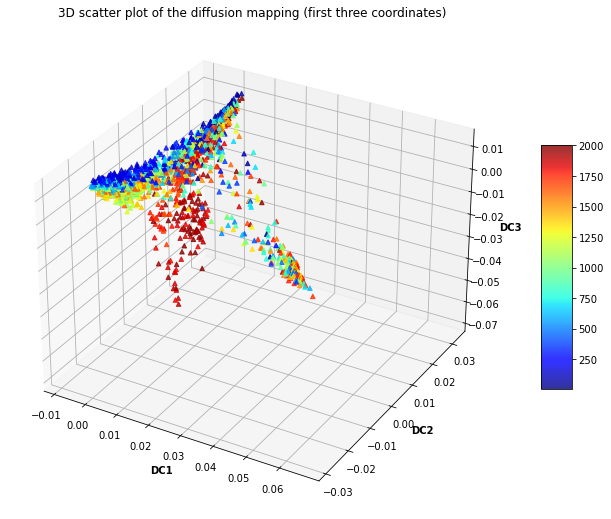

In [463]:
x = diff_map[:, 0]
y = diff_map[:, 1]
z = diff_map[:, 2]


fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)

my_cmap = plt.get_cmap('jet')
 
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = df_PSClabels["Label"],
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("3D scatter plot of the diffusion mapping (first three coordinates)")
ax.set_xlabel('DC1', fontweight ='bold')
ax.set_ylabel('DC2', fontweight ='bold')
ax.set_zlabel('DC3', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 8)

plt.show()

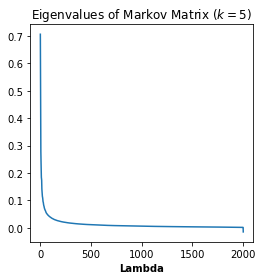

In [464]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($k = 5$)")
plt.xlabel('Lambda', fontweight ='bold')

plt.plot(np.arange(1,n), diff_eig)
plt.show()

##### k = 10

In [468]:
W = compute_affinity_matrix(E, "adaptive", k=25)
diff_vec, diff_eig = diff_map_info(W)
diff_map = get_diff_map(diff_vec, diff_eig, 1)

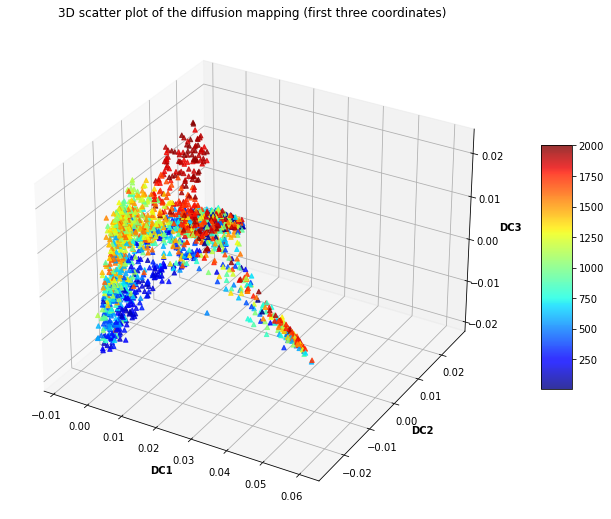

In [469]:
x = diff_map[:, 0]
y = diff_map[:, 1]
z = diff_map[:, 2]


fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)

my_cmap = plt.get_cmap('jet')
 
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = df_PSClabels["Label"],
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("3D scatter plot of the diffusion mapping (first three coordinates)")
ax.set_xlabel('DC1', fontweight ='bold')
ax.set_ylabel('DC2', fontweight ='bold')
ax.set_zlabel('DC3', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 8)

plt.show()

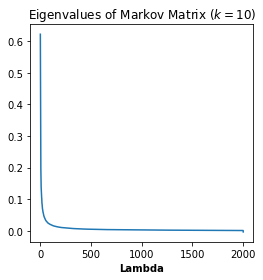

In [470]:
fig = plt.figure(figsize = (4, 4))

plt.title("Eigenvalues of Markov Matrix ($k = 10$)")
plt.xlabel('Lambda', fontweight ='bold')

plt.plot(np.arange(1,n), diff_eig)
plt.show()

#### Question 6.3

Did the choice of t affect the embeddings and, if so, how? Do the corresponding eigenvalues support your findings? How did the choice of k affect the embeddings and, if so, how? Did previously observed trends (i.e. clusters, time progression) in diffusion dimensions change dramatically? Did the correlated channels change with $\sigma$? How would you interpret this in terms of the data?

TOO BIG T WILL LEAD TO A TOO LOW EIGENVALUE (THE FIRST EIGENVALUES ARE AROUND 0.70 WHICH DRASTICALLY LOWERS THEM), SO IN THIS CASE IT IS NOT GOOD TO GO FOR A HIGH T. PRINT OUT THE FIRST THREE EIGENVALUES YOU WILL SEE THAT THEY ARE QUITE DIFFERENT AND THIS WILL CHANGE THE WAY HOW THE EMBEDDING LOOKS BECAUSE NOT EVERY AXES HAS THE SAME SHRINKAGE FACTOR. WHEN TOO HIGH T YOU PUT TOO MUCH INFORMATION ON THE FIRST EIGENVALUES